In [182]:
from sklearn.cluster import KMeans
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import glob
import crop_image
import image_analisys_functions


def printSigns(image_list, is_grey):
    f = plt.figure()
    f.set_figwidth(40)
    f.set_figheight(40)

    col_number = 3
    row_number = 7
    num = 1

    for img in image_list:
        plt.subplot(row_number, col_number, num)
        if is_grey:
            plt.imshow(img, cmap='gray', interpolation='bicubic')
        else:
            plt.imshow(img)
        num += 1


class DominantColors:
    COLORS = None
    LABLES = None
    img = None
    n = None
    dellBackground = None
    delIndex = None
    
    # to remove background from color list add 1 color as background

    def __init__(self, n=3, dellBackground=True):
        self.n = n
        self.dellBackground = dellBackground
        self.kmeans = KMeans(n_clusters=n+dellBackground, n_init='auto')

    def imgPreper_save(self, imRGB, mask):
        self.img = self.imgPreper(imRGB, mask)
        return self.img

    def imgPreper(self, imRGB, mask):
        imRGB = crop_image.applyMask(imRGB, mask)
        if (self.dellBackground == True):
            backGC = np.zeros((imRGB.shape[0], imRGB.shape[1], 3), np.uint8)
            for i in backGC:
                for j in i:
                    j[1] = 222
            # add grean
            mask = cv2.bitwise_not(mask)
            
            imRGB = cv2.bitwise_or(imRGB, cv2.bitwise_and(backGC,backGC, mask=mask))
        return imRGB

    # pass prepered img
    # return array of colors in
    # contain last image added in imgPreper_save if no argument pass
    def n_dominant_colors(self, imRGB=None):
        # deleting whit fragments
        # if mask == None:
        #     lower = np.array([0, 0, 30])  # -- Lower range --
        #     upper = np.array([255, 255, 255])  # -- Upper range --
        #     mask = cv2.inRange(imRGB, lower, upper)
        # res = cv2.bitwise_and(imRGB, imRGB, mask=mask)  # -- Contains pixels having the gray color--
        if (imRGB is None):
            imRGB = self.img

        imRGB = imRGB.reshape((imRGB.shape[1] * imRGB.shape[0], 3))

        # save image after operations

        # using k-means to cluster pixels
        self.kmeans.fit(imRGB)

        # the cluster centers are our dominant colors.
        self.COLORS = np.uint8(self.kmeans.cluster_centers_).tolist()
        self.delIndex = 0
        for i in self.COLORS :
            if(i[0] <2 and  i[1] < 224 and  i[1] > 220 and i[2] < 2): # +-2
                del self.COLORS[self.delIndex]                
                break
            self.delIndex +=1
        # print(self.COLORS)
        
        return self.COLORS
    # return array of colors in hsv

    def n_dominant_colors_conv_to_hsv(self, imRGB=None):
        # type: ignore
        return cv2.cvtColor(np.uint8([self.n_dominant_colors(imRGB)]), cv2.COLOR_RGB2HSV)

    # return array of color covered arrea
    # be carefull if you change color order
    def get_size_of_color_covered_area(self):
        tab = np.zeros(self.n+1,np.uint).tolist()
        for i in self.kmeans.labels_:
            tab[i]+=1
        if(self.delIndex <=self.n ):
            del tab[self.delIndex]
        return tab

dmc = DominantColors()

# # test kode
# filename = "znaki_idealne/A-2.png"
# HSV_mean = crop_image.findMainColor(crop_image.readImageAsHSV(filename))
# mask = crop_image.getFinalMask(crop_image.readImageAsHSV(filename),
#                                crop_image.getInsideMask(crop_image.readImageAsHSV(filename), HSV_mean))
# img = crop_image.readImageAsRGB(filename)
# # img = (crop_image.applyMask(crop_image.readImageAsRGB("znaki_idealne/A-1.png"), mask))
# ans = dmc.imgPreper(img, mask)
# # from rgb
# color = dmc.n_dominant_colors_conv_to_hsv(ans)
# print(color)
# color = dmc.get_size_of_color_covered_area()
# print(color)
# print(dmc.delIndex)



In [183]:
import itertools

#color , color2 - colory porównywane między sobą in HSV
def dopasowanieKoloru(a, color2):
    dh = (1-min(abs(a[0]-color2[0]), 179-abs(a[0]-color2[0]))/179)**3
    ds = (1-abs(a[1]-color2[1]) /255)
    dv = (1-abs(a[2]-color2[2]) / 255.0 )   
    return (dh*ds*dv)

def checkWhite(color):
    return abs(color[2]) / 255.0   *(abs(255-color[1]) / 255.0)**3   

#1 if color is black
def checkBlack(color):    
    return (abs(255-color[2]) / 255.0   )

def howDif(mesure , expected ):
    return 1 - abs(mesure -expected)

class estymarotZnaku:
    def __init__(self):
        # self.i = 0 ;
        pass
    #arr [nx3] coveraget [n]
    def est(self, arr, coverage):            

        return [self.checkA(arr, coverage, sum(coverage)),          
        self.checkB(arr, coverage,sum(coverage)) ,          
        self.checkC(arr, coverage,sum(coverage))]
    
    def checkA(self,col,coverage, allField):
        yelow = [ 30,   240,   240]
        red =   [0,   240,   240]
        yd = 0
        yc = 0
        bd = 0
        bc = 0
        rd = 0
        rc = 0
        for i, f in zip(col,coverage):
            tmp = dopasowanieKoloru(yelow, i)
            if(tmp > yd):
                yd = tmp
                yc = f
            tmp = dopasowanieKoloru(red, i)
            if(tmp > rd):
                rd = tmp
                rc = f
            tmp = checkBlack( i)
            if(tmp > bd):
                bd = tmp
                bc = f
        sum = bc+yc
        if sum > allField:
            sum = max(bc,yc)   
        return (yd*.5 +bd*.1)*howDif((sum)/allField, 0.8) +rd*.4*howDif(rc/allField, 0.2)
    
    def checkB(self,col,coverage, allField):
        red = [ 0,   250,   250]
        yd = 0
        bd = 0
        wd = 0
        yc = 0
        bc = 0
        wc = 0
        for i, f in zip(col,coverage):
    
            tmp = dopasowanieKoloru(red, i)
            if(tmp > yd):
                yd = tmp
                yc = f
            tmp = checkWhite( i)                
            if(tmp > yd):
                wd = tmp
                wc = f
            tmp = checkBlack( i)                
            if(tmp > yd):
                bd = tmp
                bc = f
        sum = yc +wc 
        if sum > allField:
            sum = max(yc,wc) 
        return (yd*.45 + wd *.45)*howDif(sum/allField,0.8) +bd*.1 * howDif(bc/allField,0.2)
    
    def checkC(self,col,coverage, allField):
        blue = [ 109,   230,   210]#101 243 199 on ideal
        yd = 0
        bd = 0
        wd = 0
        yc = 0
        bc = 0
        wc = 0
        for i, f in zip(col,coverage): 
            tmp = dopasowanieKoloru(blue, i)               
            if(tmp > yd):
                yd = tmp
                yc = f
            tmp = checkWhite(i)
            if(tmp > yd):
                wd = tmp
                wc = f
            tmp = checkBlack( i)                
            if(tmp > yd):
                bd = tmp
                bc = f
        sum = bc +wc 
        if sum > allField:
            sum = max(bc,wc) 
        return yd*.8 *howDif(yc/allField, 0.45) +( wd*.1+bd*.1)* howDif(sum/allField, 0.55)

    # def get_A(self):
    #     B =[[0,   0,   0],
    #           [0,   0, 0],
    #           [0,   0, 0]]
    #     for k in range(3):
    #         for j in range(3):
    #             B[k][j] = self.A[k][j]/self.i
    #     return B
est = estymarotZnaku()




In [184]:
def compareFn(a, b)->int:
    if a[0]==b[0]:
        if a[1]==b[1]:
            if a[2]==b[2]:
                return 0
            else:
                return a[2]-b[2]
        else:
            return a[1]-b[1]
    else:
        return a[0]-b[0]
    
def sortCol(arr):
    if compareFn(arr[0], arr[1])>0:
        tmp = arr[0].copy()
        arr[0] = arr[1]
        arr[1] = tmp
    if compareFn(arr[1], arr[2])>0:
        tmp= arr[1].copy()
        arr[1]= arr[2]
        arr[2]= tmp
    if compareFn(arr[0], arr[1])>0:
        tmp = arr[0].copy()
        arr[0]= arr[1]
        arr[1]= tmp
        
# col = [[  0, 106 ,255],[  0 ,  0 ,254], [  0,   0 ,  0] ]
# col2 = [[255, 251, 251], [253 ,251,   0], [164,  10,   4]]
# sort(col)
# print(col)
# sort(col2)
# print(col2)

In [185]:

extensions = ("*.png", "*.jpg", "*.jpeg",)
glob_list = []
for extension in extensions:
    glob_list.extend(glob.glob("znaki_pierwsze/"+extension))
    # glob_list.extend(glob.glob("znaki_pierwsze/"+extension))

image_list = []

for filename in glob_list:
    print(filename)    
    HSV_mean = crop_image.findMainColor(crop_image.readImageAsHSV(filename))
    mask = crop_image.getFinalMask(crop_image.readImageAsHSV(filename), crop_image.getInsideMask(crop_image.readImageAsHSV(filename),HSV_mean))
    image_list.append(crop_image.applyMask(crop_image.readImageAsRGB(filename), mask))
    # from rgb 
    ans = dmc.imgPreper(image_list[-1], mask)
    color = dmc.n_dominant_colors_conv_to_hsv(ans )
    # print(color[0])
    # print(checkWhite(color[0][0]))
    # print(checkWhite(color[0][1]))
    # print(checkWhite(color[0][2]))
    # print(dmc.get_size_of_color_covered_area())
    print(est.est(color[0],dmc.get_size_of_color_covered_area()))

    
    # image_list.append(mask)

znaki_pierwsze\A-7_1.jpg
[0.587463984452819, 0.19406581567923314, 0.09641491151255219]
znaki_pierwsze\A-7_2.jpg
[0.6896230063655915, 0.10312005276860856, 0.09334243138902804]
znaki_pierwsze\A-7_3.jpg
[0.5559595620080725, 0.19919620312623085, 0.08198043103004736]
znaki_pierwsze\A-7_5.jpg
[0.6580876484394161, 0.12635666390880695, 0.11782277604039838]
znaki_pierwsze\B-2_1.jpg
[0.3567993658097458, 0.4895384819086778, 0.2073802718028468]
znaki_pierwsze\B-2_3.jpg
[0.23706200085944626, 0.40860171836275344, 0.13985345225799156]
znaki_pierwsze\B-2_4.jpg
[0.4862695032432031, 0.28044282884506155, 0.15129158593333167]
znaki_pierwsze\B-2_5.jpg
[0.36883966115107614, 0.6137226969036931, 0.10182236941763233]
znaki_pierwsze\C-12_1.jpg
[0.1129819763765549, 0.2225436328012377, 0.47561781343162685]
znaki_pierwsze\C-12_3.jpg
[0.14788018410365647, 0.29831933610685574, 0.6419595364919763]
znaki_pierwsze\C-12_4.jpg
[0.1249824479099197, 0.18602045581644805, 0.698422617449943]
znaki_pierwsze\C-12_5.jpg
[0.12335

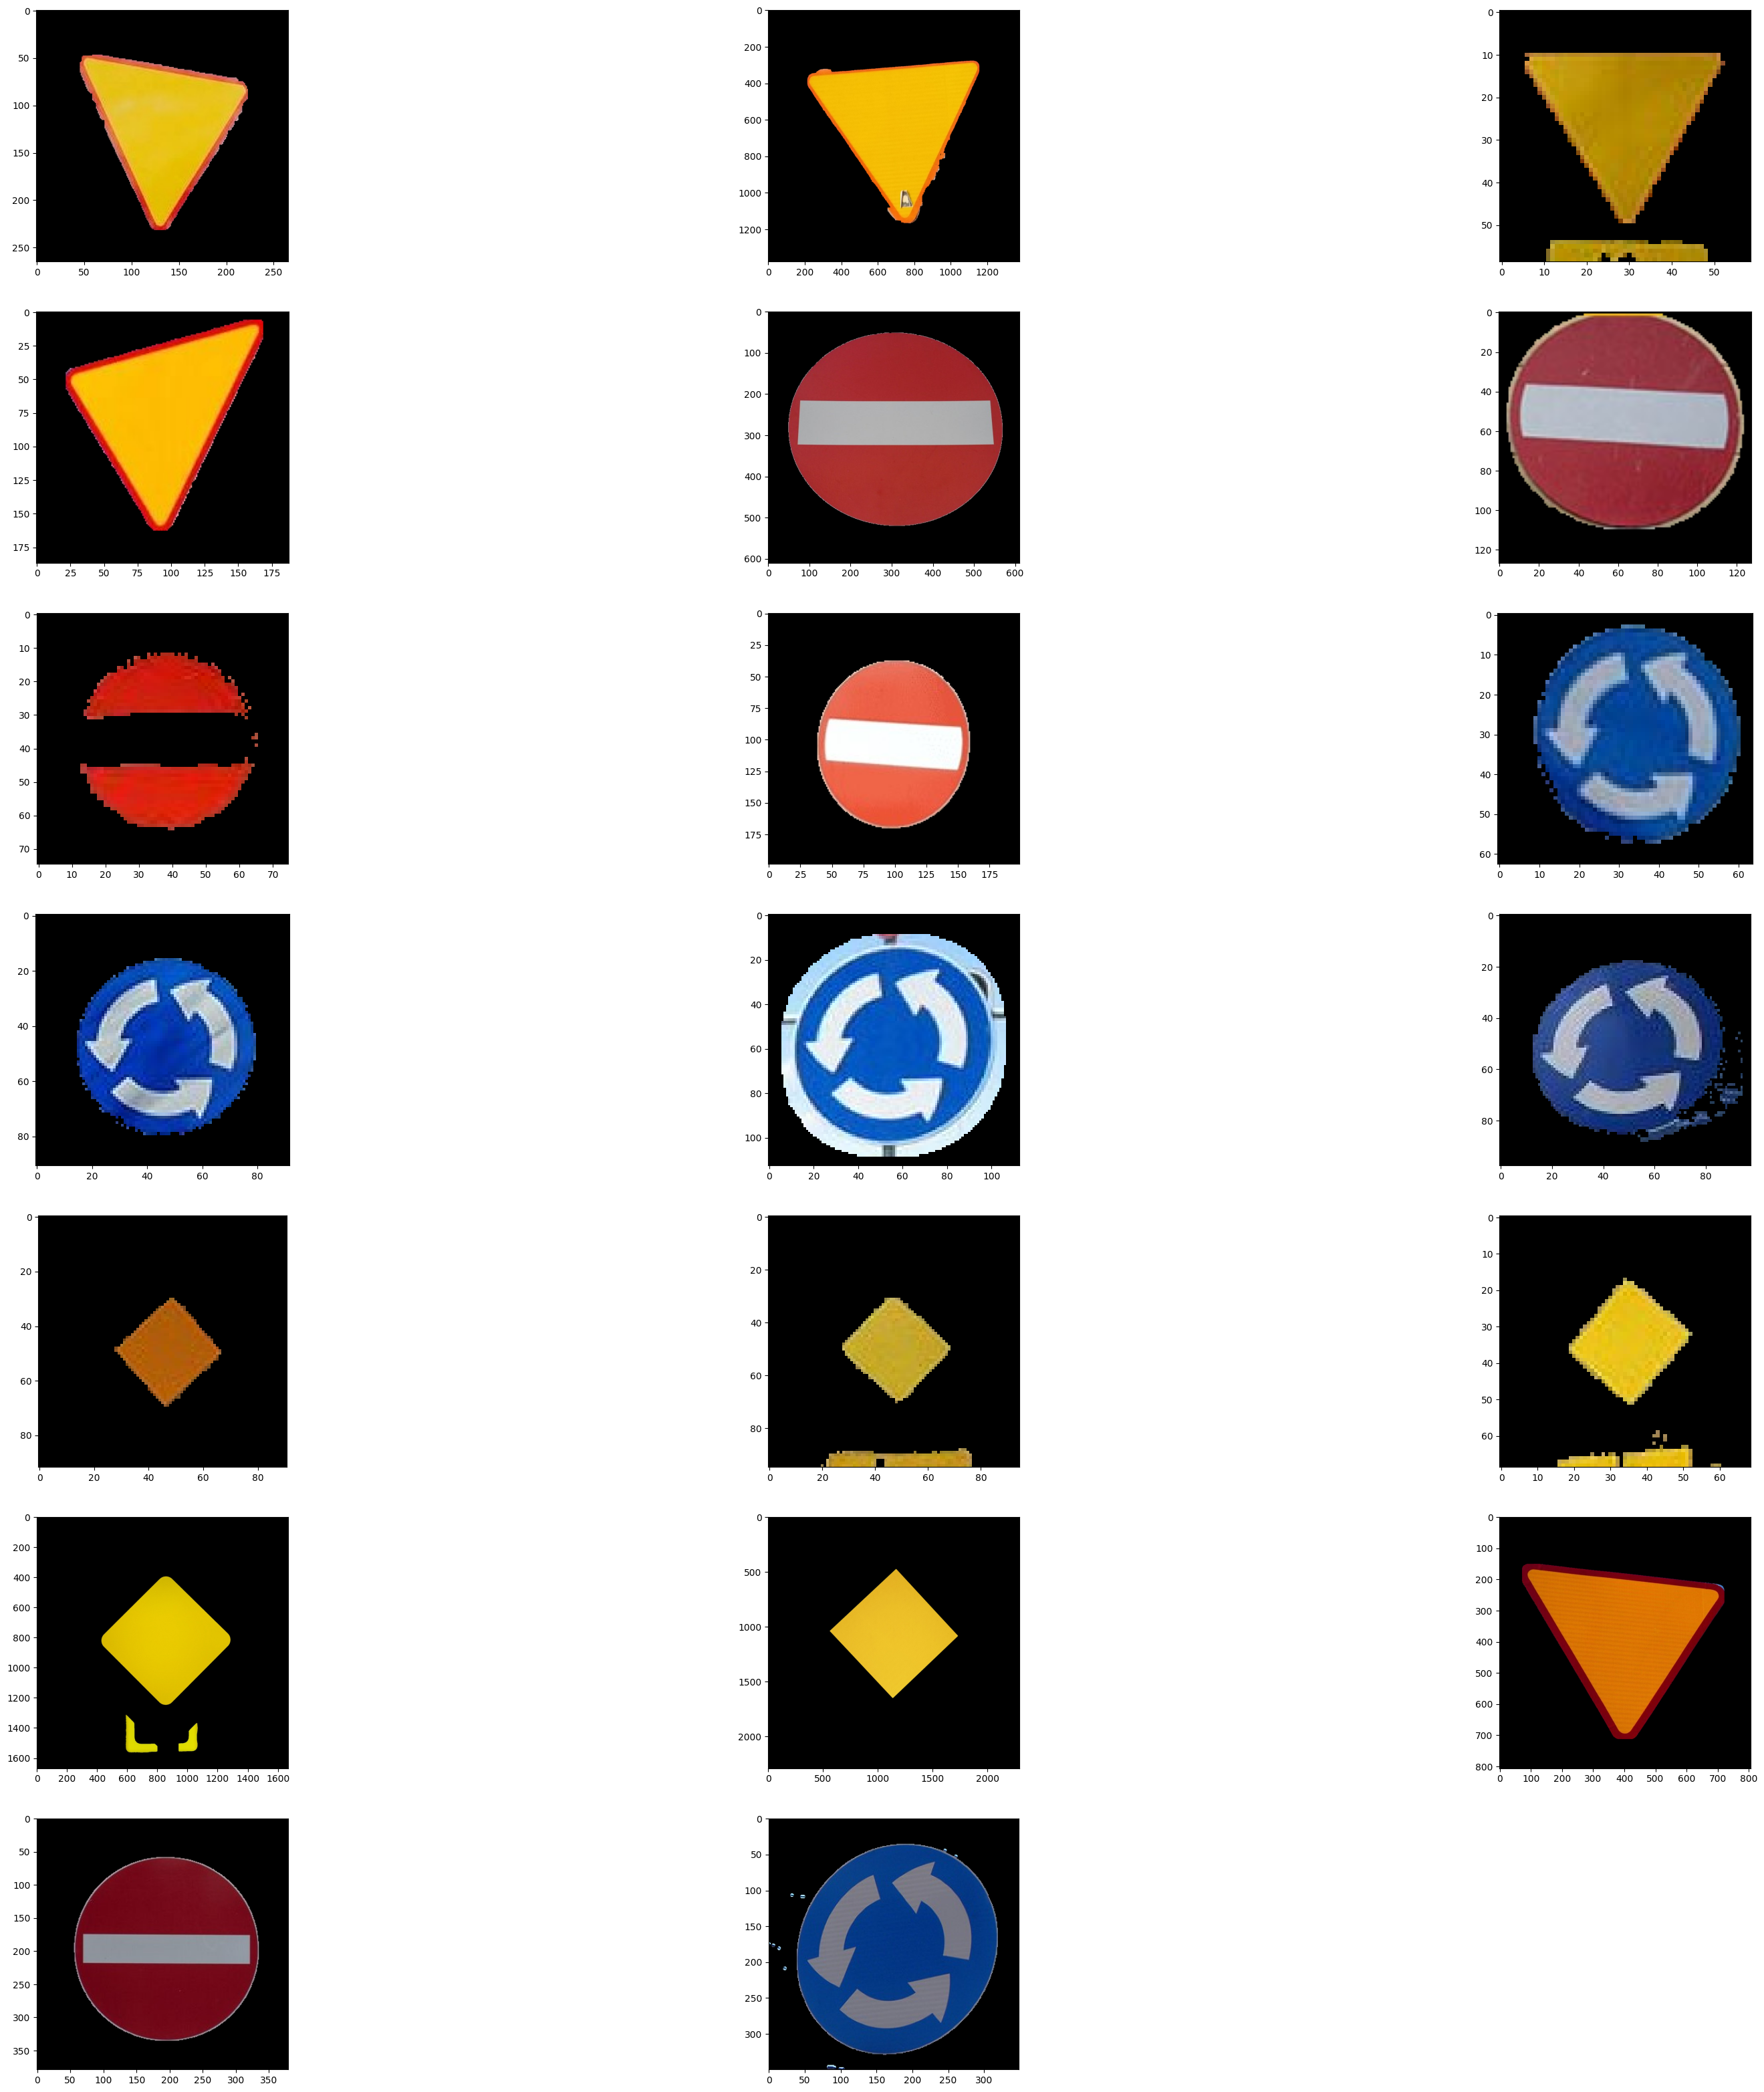

In [186]:
printSigns(image_list, False)